In [135]:
from pathlib import Path
%pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [136]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow_addons as tfa

LABELS = ['positive', 'neutral', 'negative']

SAVE_MODEL = True
DUMP_DIRECTORY = 'created_models'

TRAIN_RANDOM_STATE = 42
DEV_RANDOM_STATE = 42

DROP=0.2
LAYER_1_DENSITY = 1024
LAYER_2_DENSITY = 512
LAYER_3_DENSITY = 256
ACTIVATION = 'sigmoid'

NUM_WORDS = 10000
SEQ_MAX_LEN = 24
EMBEDDING_DIMENSIONS = 30
LAST_DIMENSIONS = 3 #based on labels
LAST_ACTIVATION = 'softmax'

NUM_EPOCHS = 150
BATCH_SIZE = 60
COMPILE_LOSS = 'categorical_crossentropy'
COMPILE_METRICS = ['accuracy']

GLOVE_DIMENSIONS = 100


In [137]:
import os
from datetime import datetime

import joblib


def dump_file(o, object_name, name):
    if not os.path.exists(DUMP_DIRECTORY):
        os.mkdir(DUMP_DIRECTORY)
    time = datetime.now().strftime("%d%b%Y%H%M%S")
    created_model_path = DUMP_DIRECTORY + '/' + name + '_' + time + '.dump'
    joblib.dump(o, created_model_path)

In [138]:
from nltk.corpus import stopwords
from sklearn.utils import shuffle

HEADER = ['id1', 'id2', 'sentiment', 'tweet_text']
HEADER_TO_DELETE = ['id1', 'id2']
ps = nltk.SnowballStemmer('english')

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def remove_mentions(input_text):
    input_text = re.sub(r'@\w+', '', input_text)
    return re.sub(r'#\w+', '', input_text)

def clean(dataset, col='tweet_text', not_equals_text='Not Available'):
    return dataset[dataset[col] != not_equals_text]

def merge_neutrals(dataset):
    neutral_sentiments = ['objective', 'objective-OR-neutral']
    dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 'neutral' if x in neutral_sentiments else x)
    return dataset

def preprocess_words(input_text):
    input_text = input_text.lower()
    return ' '.join([ps.stem(word) for word in input_text.split()])

def evaluate(predict, labels):
    print('Classification report:')
    print(classification_report(labels, predict))
    print('Accuracy:')
    print(accuracy_score(labels, predict))

    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(labels, predict),
                         index=[i for i in ['positive', 'neutral', 'negative']],
                         columns=[i for i in ['positive', 'neutral', 'negative']])
    plt.figure(figsize=(10,7))
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    plt.show()


train_dataset = pd.read_csv('db/train.tsv', sep='\t', header=None, names=HEADER)
train_dataset = shuffle(train_dataset, random_state=TRAIN_RANDOM_STATE)
train_dataset = clean(train_dataset)
train_dataset = merge_neutrals(train_dataset)
train_dataset.drop(HEADER_TO_DELETE, axis=1, inplace=True)
train_dataset['tweet_text'] = train_dataset['tweet_text'].apply(remove_stopwords).apply(remove_mentions).apply(preprocess_words)
train_dataset.info()

dev_dataset = pd.read_csv('db/dev-full.tsv', sep='\t', header=None, names=HEADER)
dev_dataset = shuffle(dev_dataset, random_state=DEV_RANDOM_STATE)
dev_dataset = clean(dev_dataset)
dev_dataset = merge_neutrals(dev_dataset)
dev_dataset.drop(HEADER_TO_DELETE, axis=1, inplace=True)
dev_dataset['tweet_text'] = dev_dataset['tweet_text'].apply(remove_stopwords).apply(remove_mentions).apply(preprocess_words)
dev_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6275 entries, 5821 to 7270
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   6275 non-null   object
 1   tweet_text  6275 non-null   object
dtypes: object(2)
memory usage: 147.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 65 to 1126
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   1051 non-null   object
 1   tweet_text  1051 non-null   object
dtypes: object(2)
memory usage: 24.6+ KB


In [139]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate(predict, labels, history):
    print('Classification report:')
    print(classification_report(labels, predict))
    print('Accuracy:')
    print(accuracy_score(labels, predict))

    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(labels, predict),
                         index=[i for i in ['positive', 'neutral', 'negative']],
                         columns=[i for i in ['positive', 'neutral', 'negative']])
    plt.figure(figsize=(10,7))
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train acc', 'val acc'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'val loss'], loc='upper left')
    plt.show()

x_train = train_dataset['tweet_text'].values
y_train = train_dataset['sentiment'].values

x_dev = dev_dataset['tweet_text'].values
y_dev = dev_dataset['sentiment'].values

train_dataset.head(5)

,sentiment,tweet_text
5821,neutral,i'm bout listen nicki minaj night
2833,positive,see c. edward anyth race hard thur duel i'm su...
2543,positive,fux wit yo 3rd choic gift hand (the ben carson...
1737,positive,"first time list red: ""doe diva think avril lav..."
6582,positive,congrat lloyd robertson gordon sinclair award ...


In [140]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tk = Tokenizer(num_words=NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',
               lower=True, split=" ")
tk.fit_on_texts(x_train)
x_train_seq = tk.texts_to_sequences(x_train)
x_dev_seq = tk.texts_to_sequences(x_dev)

x_train_seq_trunc = pad_sequences(x_train_seq, maxlen=SEQ_MAX_LEN)
x_dev_seq_trunc = pad_sequences(x_dev_seq, maxlen=SEQ_MAX_LEN)

In [141]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_dev_le = le.fit_transform(y_dev)
y_train_categorical = to_categorical(y_train_le)
y_dev_categorical = to_categorical(y_dev_le)

In [142]:
from keras import models
from keras import layers

emb_model = models.Sequential()
emb_model.add(layers.Embedding(NUM_WORDS, EMBEDDING_DIMENSIONS, input_length=SEQ_MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(LAST_DIMENSIONS, activation=LAST_ACTIVATION))
emb_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 24, 30)            300000    
_________________________________________________________________
flatten_14 (Flatten)         (None, 720)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 2163      
Total params: 302,163
Trainable params: 302,163
Non-trainable params: 0
_________________________________________________________________


In [143]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()
from tensorflow.python.keras.callbacks import EarlyStopping

def deep_model(model, x_train, y_train, x_dev, y_dev):
    model.compile(loss=COMPILE_LOSS, metrics=COMPILE_METRICS)

    history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(x_dev, y_dev), verbose=0, callbacks=[EarlyStopping(patience=2), tqdm_callback])
    # TODO: shuffle -> random state, with seeds
    # if SAVE_MODEL:
    #   dump_file(model, 'neural net', 'deep_model')

    result = model.evaluate(x_dev, y_dev)
    predict = model.predict_classes(x_dev)

    return history, result, predict


In [144]:
emb_history, emb_result, emb_predict = deep_model(emb_model, x_train_seq_trunc, y_train_categorical,
                         x_dev_seq_trunc, y_dev_categorical)

Training:   0%|           0/150 ETA: ?s,  ?epochs/s

Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
33/33 [==============================] - 0s 849us/step - loss: 0.9391 - accuracy: 0.5728


0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

[0.9390789270401001, 0.5727878212928772]
Classification report:
              precision    recall  f1-score   support

           0       0.34      0.09      0.14       205
           1       0.60      0.71      0.65       470
           2       0.56      0.66      0.61       376

    accuracy                           0.57      1051
   macro avg       0.50      0.49      0.47      1051
weighted avg       0.54      0.57      0.54      1051

Accuracy:
0.5727878211227403
Confusion matrix:


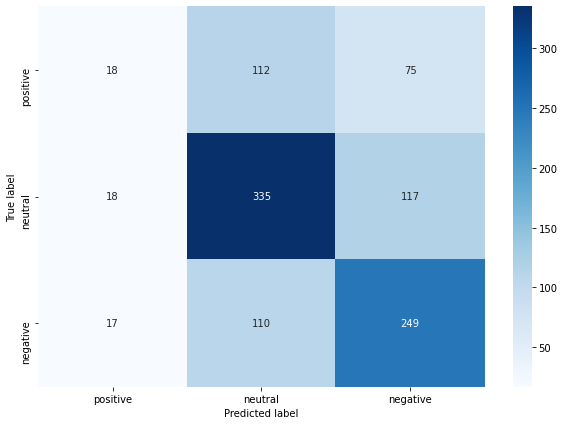

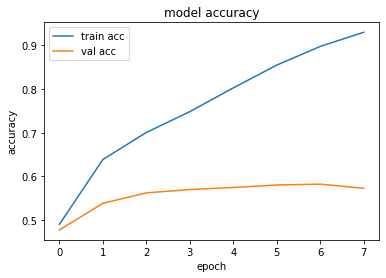

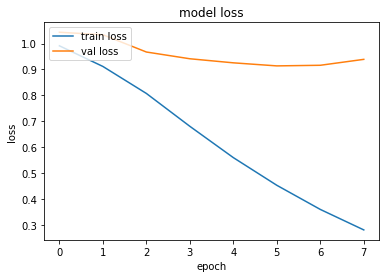

In [145]:
print(emb_result)
evaluate(emb_predict, y_dev_le, emb_history)

In [146]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIMENSIONS) + 'd.txt'
emb_dict = {}
glove = open(Path('./db') / glove_file, encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [147]:

emb_matrix = np.zeros((NUM_WORDS, GLOVE_DIMENSIONS))

for w, i in tk.word_index.items():
    if i < NUM_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [148]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NUM_WORDS, GLOVE_DIMENSIONS, input_length=SEQ_MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(3, activation='softmax'))
glove_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 24, 100)           1000000   
_________________________________________________________________
flatten_15 (Flatten)         (None, 2400)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 7203      
Total params: 1,007,203
Trainable params: 1,007,203
Non-trainable params: 0
_________________________________________________________________


In [149]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

glove_history, glove_result, glove_predict = deep_model(glove_model, x_train_seq_trunc, y_train_categorical,
                                                        x_dev_seq_trunc, y_dev_categorical)

Training:   0%|           0/150 ETA: ?s,  ?epochs/s

Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
33/33 [==============================] - 0s 2ms/step - loss: 0.9547 - accuracy: 0.5775


0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

0/105           ETA: ?s - 

[0.9547168016433716, 0.577545166015625]
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25       205
           1       0.61      0.68      0.64       470
           2       0.55      0.67      0.61       376

    accuracy                           0.58      1051
   macro avg       0.55      0.51      0.50      1051
weighted avg       0.57      0.58      0.55      1051

Accuracy:
0.5775451950523312
Confusion matrix:


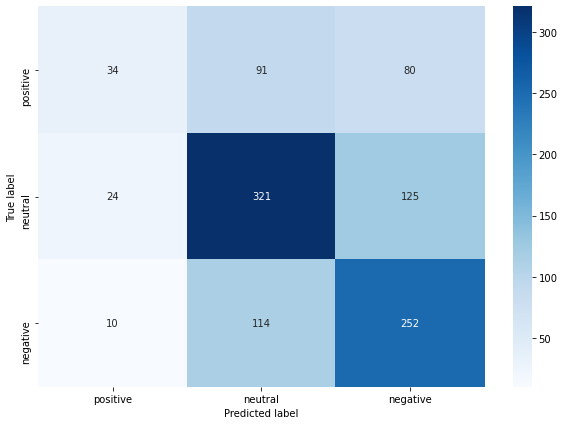

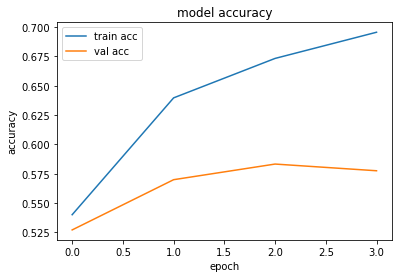

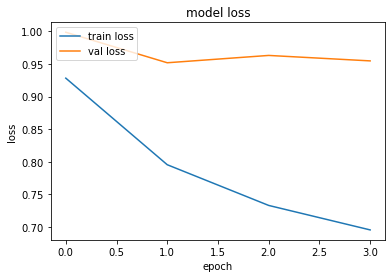

In [150]:
print(glove_result)
evaluate(glove_predict, y_dev_le, glove_history)